In [1]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [2]:
# system
import sys
sys.path.append('..')

# data
import numpy as np

# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# torchvision
import torchvision

# plotting
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# utils and model
from utils.utils import (
    seedEverything,
    compute_mean_std,
    data_transform,
    normalize,
    plot_images,
)

from utils.model import ConvNN

# FIXMATCH
from fixmatch_DA import fixmatch_DA_train

# os
import os
import path

# sklearn - confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


%load_ext autoreload
%autoreload 2

In [3]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [4]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.9
LAMBDA_U = 3
MU = 4
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.0005

In [5]:
# Download both datasets
trainset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=data_transform())
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=data_transform())

# convert to data loaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# compute mean and std
if not os.path.exists('../data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, '../data/mean.pt')
    torch.save(std, '../data/std.pt')
else:
    mean, std = torch.load('../data/mean.pt'), torch.load('../data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")

mean: [0.49142736 0.48217902 0.4465423 ], std: [0.24636985 0.24283184 0.26074585]


In [7]:
# define classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [8]:
torch_models = './results/models/' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## III. Semi-Supervised Learning: Fixmatch

### III.1 Fixmatch on 10% train data

In [9]:
# fix the seed
seedEverything()

SUBSET_PROP = 0.10

# load indices
indices_10 = torch.load('../SPLITS/SPLIT_10_MAX.pt')

trainset_sup = torch.utils.data.Subset(trainset, indices_10)

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [10]:
EPOCHS = 200

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(labeled_dataloader) * EPOCHS, eta_min=1e-4)

In [11]:
fixmatch_DA_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='10_CORESET'
)

Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 21.65%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 31.63%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 35.2%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 40.74%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 40.67%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 37.87%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.23%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 48.55%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.9%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 53.05%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.28%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.74%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.74%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 56.77%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 56.08%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.98%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.81%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.74%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.44%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.09%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.88%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.25%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.1%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.16%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.6%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.1%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.84%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.45%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.94%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.91%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.46%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.49%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.95%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.27%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.84%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.94%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.5%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.2%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.49%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.9%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.05%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.14%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.75%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.17%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.52%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.29%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.32%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.78%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.28%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.19%


Epoch    50:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.49%


Epoch    51:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.64%


Epoch    52:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.89%


Epoch    53:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.33%


Epoch    54:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.83%


Epoch    55:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.58%


Epoch    56:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.73%


Epoch    57:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.53%


Epoch    58:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.22%


Epoch    59:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.4%


Epoch    60:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.32%


Epoch    61:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.44%


Epoch    62:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.44%


Epoch    63:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.07%


Epoch    64:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.05%


Epoch    65:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.02%


Epoch    66:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.17%


Epoch    67:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.31%


Epoch    68:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.73%


Epoch    69:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.95%


Epoch    70:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.21%


Epoch    71:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.18%


Epoch    72:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.71%


Epoch    73:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.47%


Epoch    74:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.46%


Epoch    75:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.26%


Epoch    76:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.49%


Epoch    77:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.48%


Epoch    78:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.64%


Epoch    79:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.38%


Epoch    80:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.81%


Epoch    81:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.32%


Epoch    82:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.89%


Epoch    83:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.4%


Epoch    84:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.5%


Epoch    85:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.34%


Epoch    86:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.55%


Epoch    87:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.26%


Epoch    88:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.9%


Epoch    89:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.59%


Epoch    90:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.1%


Epoch    91:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.75%


Epoch    92:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.39%


Epoch    93:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.86%


Epoch    94:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.19%


Epoch    95:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.72%


Epoch    96:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.94%


Epoch    97:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.56%


Epoch    98:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.63%


Epoch    99:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.8%


Epoch   100:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.96%


Epoch   101:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.38%


Epoch   102:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.51%


Epoch   103:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.09%


Epoch   104:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.29%


Epoch   105:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.03%


Epoch   106:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.99%


Epoch   107:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.18%


Epoch   108:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.13%


Epoch   109:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.76%


Epoch   110:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.78%


Epoch   111:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.86%


Epoch   112:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.15%


Epoch   113:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.16%


Epoch   114:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.65%


Epoch   115:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.77%


Epoch   116:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.52%


Epoch   117:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.79%


Epoch   118:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.91%


Epoch   119:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.48%


Epoch   120:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.32%


Epoch   121:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.93%


Epoch   122:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.1%


Epoch   123:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.4%


Epoch   124:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.36%


Epoch   125:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.33%


Epoch   126:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.32%


Epoch   127:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.57%


Epoch   128:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.1%


Epoch   129:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.04%


Epoch   130:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.8%


Epoch   131:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.09%


Epoch   132:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.65%


Epoch   133:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.8%


Epoch   134:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.94%


Epoch   135:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.02%


Epoch   136:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.06%


Epoch   137:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.35%


Epoch   138:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.82%


Epoch   139:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.52%


Epoch   140:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.7%


Epoch   141:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.75%


Epoch   142:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.05%


Epoch   143:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.1%


Epoch   144:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.83%


Epoch   145:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.22%


Epoch   146:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.25%


Epoch   147:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.4%


Epoch   148:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.39%


Epoch   149:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.13%


Epoch   150:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.28%


Epoch   151:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.09%


Epoch   152:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.63%


Epoch   153:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.66%


Epoch   154:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.91%


Epoch   155:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.69%


Epoch   156:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.67%


Epoch   157:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.0%


Epoch   158:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.94%


Epoch   159:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.64%


Epoch   160:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.85%


Epoch   161:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.27%


Epoch   162:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.76%


Epoch   163:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.36%


Epoch   164:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.9%


Epoch   165:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.98%


Epoch   166:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.96%


Epoch   167:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.49%


Epoch   168:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.21%


Epoch   169:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.23%


Epoch   170:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.61%


Epoch   171:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.28%


Epoch   172:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.46%


Epoch   173:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.79%


Epoch   174:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.11%


Epoch   175:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.74%


Epoch   176:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.39%


Epoch   177:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.2%


Epoch   178:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.47%


Epoch   179:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.86%


Epoch   180:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.56%


Epoch   181:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.95%


Epoch   182:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.69%


Epoch   183:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.69%


Epoch   184:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.73%


Epoch   185:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.6%


Epoch   186:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.87%


Epoch   187:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.96%


Epoch   188:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.78%


Epoch   189:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.96%


Epoch   190:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.95%


Epoch   191:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.78%


Epoch   192:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.85%


Epoch   193:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.96%


Epoch   194:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.03%


Epoch   195:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.07%


Epoch   196:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.01%


Epoch   197:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.98%


Epoch   198:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.76%


Epoch   199:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.88%
Finished Training


In [12]:
# open results
model_10 = ConvNN().to(device)
model_10.load_state_dict(torch.load('./results/models/model_DA_10_CORESET.pth'))
train_losses_10 = torch.load('./results/metrics/train_losses_DA_10_CORESET.pth')
train_accuracies_10 = torch.load('./results/metrics/train_accuracies_DA_10_CORESET.pth')
test_losses_10 = torch.load('./results/metrics/test_losses_DA_10_CORESET.pth')
test_accuracies_10 = torch.load('./results/metrics/test_accuracies_DA_10_CORESET.pth')

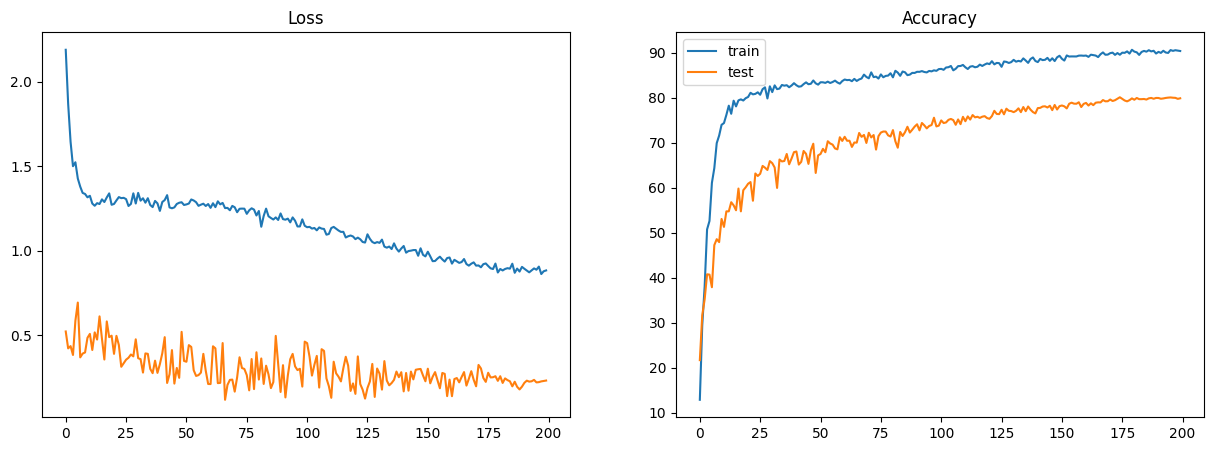

In [13]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_10, label="train")
ax1.plot(test_losses_10, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_10, label="train")
ax2.plot(test_accuracies_10, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_DA_10_CORESET.png")

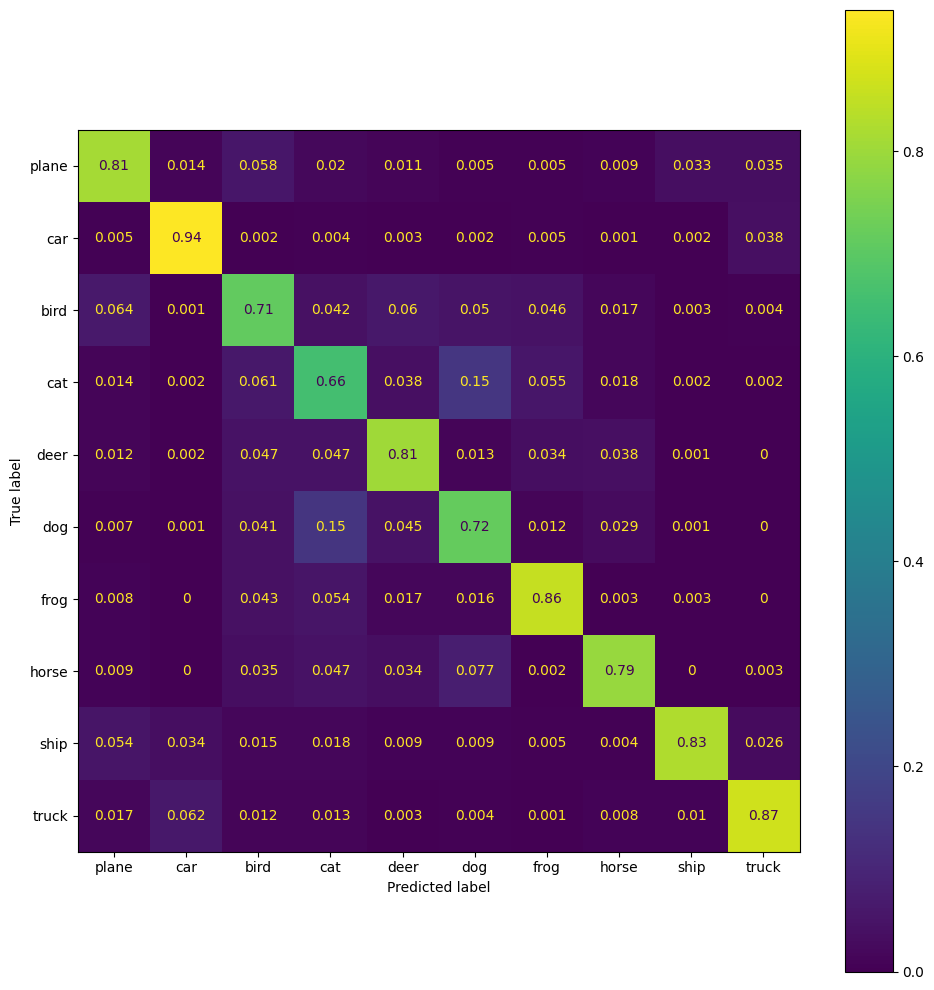

In [14]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_10(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_DA_10_CORESET.png")

Test Accuracy: 79.88%


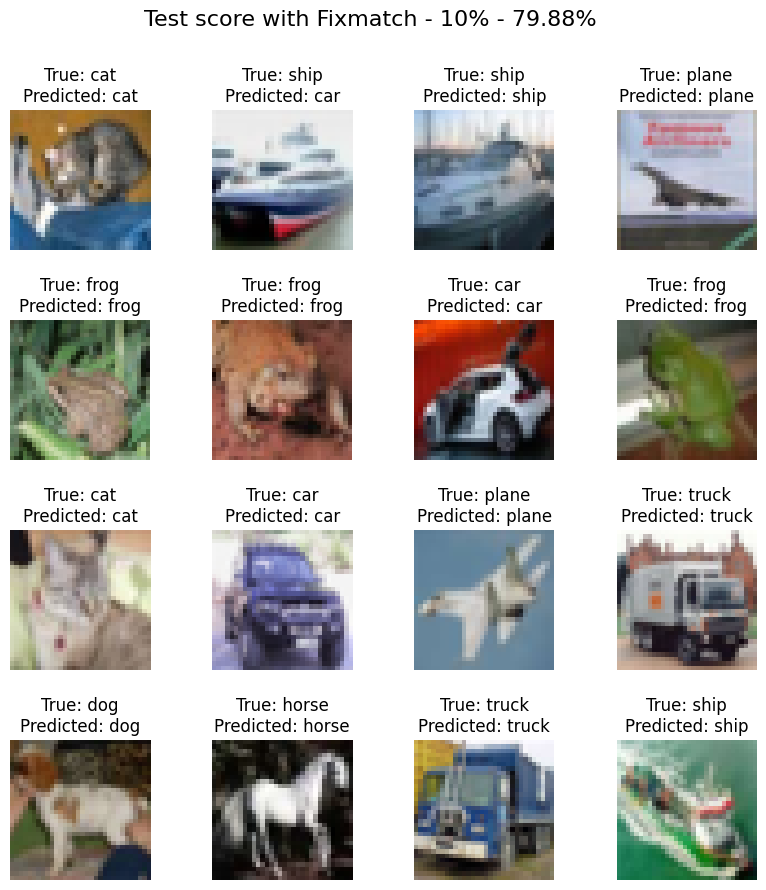

In [15]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_10(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_DA_10_CORESET.png")

### III.2 Fixmatch on 5% train data

In [16]:
# fix the seed
seedEverything()

SUBSET_PROP = 0.05

# load indices
indices_05 = torch.load('../SPLITS/SPLIT_05_MAX.pt')

trainset_sup = torch.utils.data.Subset(trainset, indices_05)

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [17]:
EPOCHS = 200

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(labeled_dataloader) * EPOCHS, eta_min=1e-4)

In [18]:
fixmatch_DA_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='05_CORESET'
)

Start training


Epoch     0:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 22.29%


Epoch     1:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 26.72%


Epoch     2:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 32.9%


Epoch     3:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 35.28%


Epoch     4:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 32.06%


Epoch     5:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 39.51%


Epoch     6:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.14%


Epoch     7:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.38%


Epoch     8:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 35.02%


Epoch     9:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.54%


Epoch    10:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 43.01%


Epoch    11:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 44.63%


Epoch    12:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.01%


Epoch    13:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 38.41%


Epoch    14:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.28%


Epoch    15:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.53%


Epoch    16:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.94%


Epoch    17:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.93%


Epoch    18:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.21%


Epoch    19:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.43%


Epoch    20:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.66%


Epoch    21:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.62%


Epoch    22:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 52.31%


Epoch    23:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.22%


Epoch    24:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.13%


Epoch    25:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.63%


Epoch    26:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.74%


Epoch    27:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.46%


Epoch    28:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.84%


Epoch    29:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.92%


Epoch    30:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.1%


Epoch    31:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.39%


Epoch    32:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.33%


Epoch    33:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.35%


Epoch    34:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.08%


Epoch    35:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.41%


Epoch    36:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.55%


Epoch    37:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.06%


Epoch    38:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.58%


Epoch    39:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.08%


Epoch    40:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.96%


Epoch    41:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.01%


Epoch    42:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.61%


Epoch    43:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.31%


Epoch    44:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.74%


Epoch    45:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.2%


Epoch    46:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.02%


Epoch    47:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.85%


Epoch    48:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.46%


Epoch    49:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.84%


Epoch    50:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.34%


Epoch    51:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.18%


Epoch    52:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.65%


Epoch    53:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.93%


Epoch    54:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.55%


Epoch    55:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.65%


Epoch    56:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.36%


Epoch    57:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.78%


Epoch    58:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.95%


Epoch    59:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.44%


Epoch    60:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.75%


Epoch    61:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.32%


Epoch    62:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.85%


Epoch    63:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.91%


Epoch    64:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.1%


Epoch    65:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.45%


Epoch    66:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.25%


Epoch    67:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.5%


Epoch    68:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.38%


Epoch    69:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.29%


Epoch    70:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.45%


Epoch    71:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.7%


Epoch    72:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.28%


Epoch    73:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.87%


Epoch    74:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.45%


Epoch    75:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.38%


Epoch    76:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.32%


Epoch    77:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.82%


Epoch    78:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.96%


Epoch    79:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.08%


Epoch    80:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.77%


Epoch    81:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.76%


Epoch    82:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.39%


Epoch    83:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.6%


Epoch    84:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.21%


Epoch    85:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.22%


Epoch    86:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.42%


Epoch    87:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.18%


Epoch    88:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.63%


Epoch    89:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.95%


Epoch    90:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.25%


Epoch    91:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.53%


Epoch    92:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.69%


Epoch    93:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.63%


Epoch    94:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.19%


Epoch    95:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.33%


Epoch    96:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.01%


Epoch    97:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.08%


Epoch    98:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.91%


Epoch    99:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.11%


Epoch   100:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.59%


Epoch   101:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.73%


Epoch   102:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.92%


Epoch   103:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.33%


Epoch   104:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.15%


Epoch   105:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.61%


Epoch   106:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.01%


Epoch   107:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.81%


Epoch   108:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.9%


Epoch   109:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.07%


Epoch   110:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.84%


Epoch   111:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.42%


Epoch   112:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.64%


Epoch   113:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.13%


Epoch   114:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.96%


Epoch   115:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.91%


Epoch   116:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.76%


Epoch   117:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.84%


Epoch   118:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.04%


Epoch   119:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.01%


Epoch   120:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.2%


Epoch   121:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.54%


Epoch   122:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.55%


Epoch   123:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.89%


Epoch   124:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.02%


Epoch   125:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.11%


Epoch   126:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.63%


Epoch   127:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.01%


Epoch   128:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.18%


Epoch   129:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.0%


Epoch   130:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.68%


Epoch   131:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.58%


Epoch   132:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.4%


Epoch   133:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.99%


Epoch   134:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.16%


Epoch   135:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.05%


Epoch   136:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.89%


Epoch   137:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.54%


Epoch   138:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.32%


Epoch   139:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.34%


Epoch   140:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.31%


Epoch   141:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.58%


Epoch   142:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.19%


Epoch   143:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.99%


Epoch   144:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.83%


Epoch   145:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.37%


Epoch   146:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.22%


Epoch   147:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.69%


Epoch   148:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.63%


Epoch   149:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.87%


Epoch   150:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.43%


Epoch   151:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.2%


Epoch   152:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.13%


Epoch   153:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.02%


Epoch   154:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.7%


Epoch   155:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.62%


Epoch   156:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.62%


Epoch   157:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.29%


Epoch   158:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.96%


Epoch   159:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.93%


Epoch   160:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.74%


Epoch   161:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.52%


Epoch   162:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.28%


Epoch   163:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.48%


Epoch   164:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.0%


Epoch   165:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.65%


Epoch   166:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.85%


Epoch   167:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.89%


Epoch   168:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.45%


Epoch   169:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.19%


Epoch   170:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.67%


Epoch   171:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.85%


Epoch   172:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.73%


Epoch   173:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.83%


Epoch   174:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.63%


Epoch   175:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.63%


Epoch   176:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.82%


Epoch   177:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.7%


Epoch   178:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.88%


Epoch   179:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.82%


Epoch   180:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.7%


Epoch   181:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.88%


Epoch   182:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.0%


Epoch   183:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.06%


Epoch   184:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.93%


Epoch   185:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.02%


Epoch   186:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.08%


Epoch   187:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.0%


Epoch   188:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.04%


Epoch   189:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.23%


Epoch   190:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.16%


Epoch   191:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.06%


Epoch   192:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.06%


Epoch   193:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.18%


Epoch   194:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.19%


Epoch   195:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.15%


Epoch   196:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.13%


Epoch   197:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.16%


Epoch   198:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.15%


Epoch   199:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.19%
Finished Training


In [19]:
# open results
model_05 = ConvNN().to(device)
model_05.load_state_dict(torch.load('./results/models/model_DA_05_CORESET.pth'))
train_losses_05 = torch.load('./results/metrics/train_losses_DA_05_CORESET.pth')
train_accuracies_05 = torch.load('./results/metrics/train_accuracies_DA_05_CORESET.pth')
test_losses_05 = torch.load('./results/metrics/test_losses_DA_05_CORESET.pth')
test_accuracies_05 = torch.load('./results/metrics/test_accuracies_DA_05_CORESET.pth')

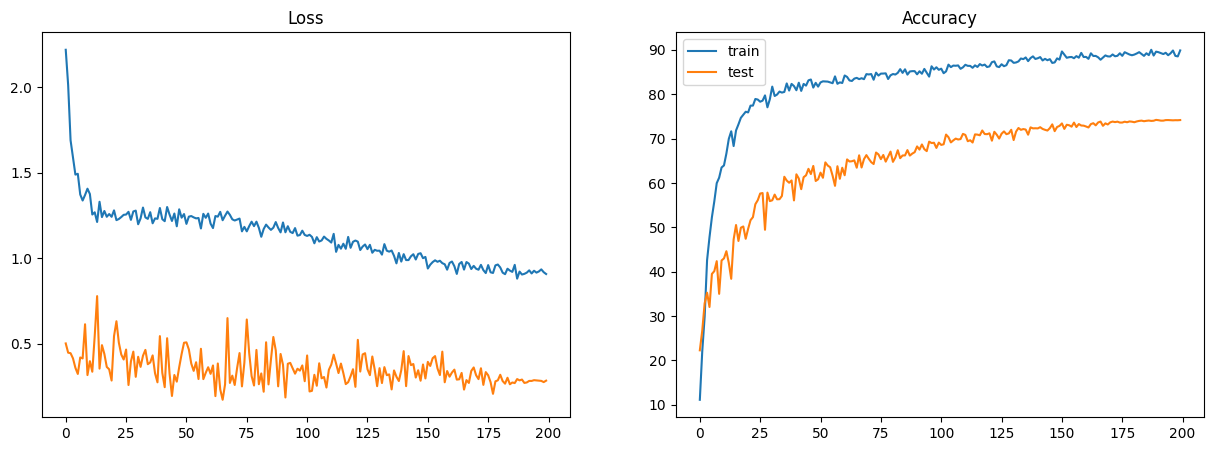

In [20]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_05, label="train")
ax1.plot(test_losses_05, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_05, label="train")
ax2.plot(test_accuracies_05, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_DA_05_CORESET.png")

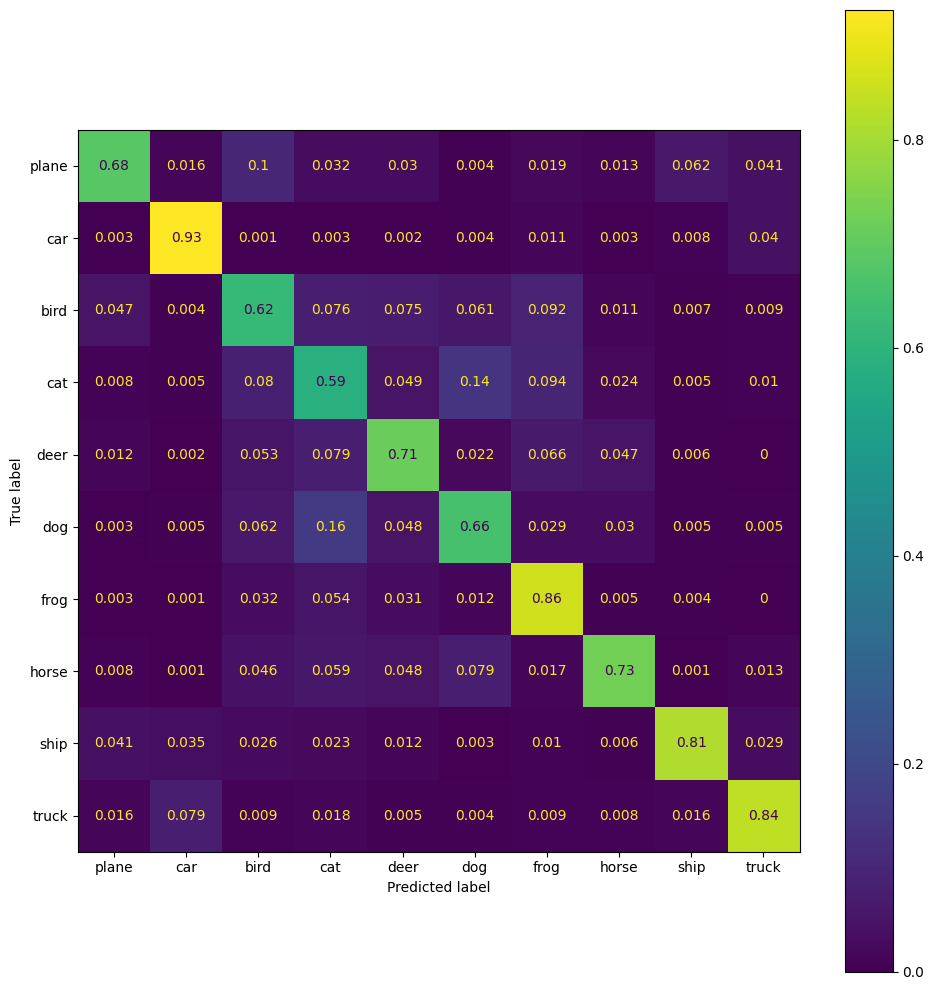

In [21]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_05(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_DA_05_CORESET.png")

Test Accuracy: 74.19%


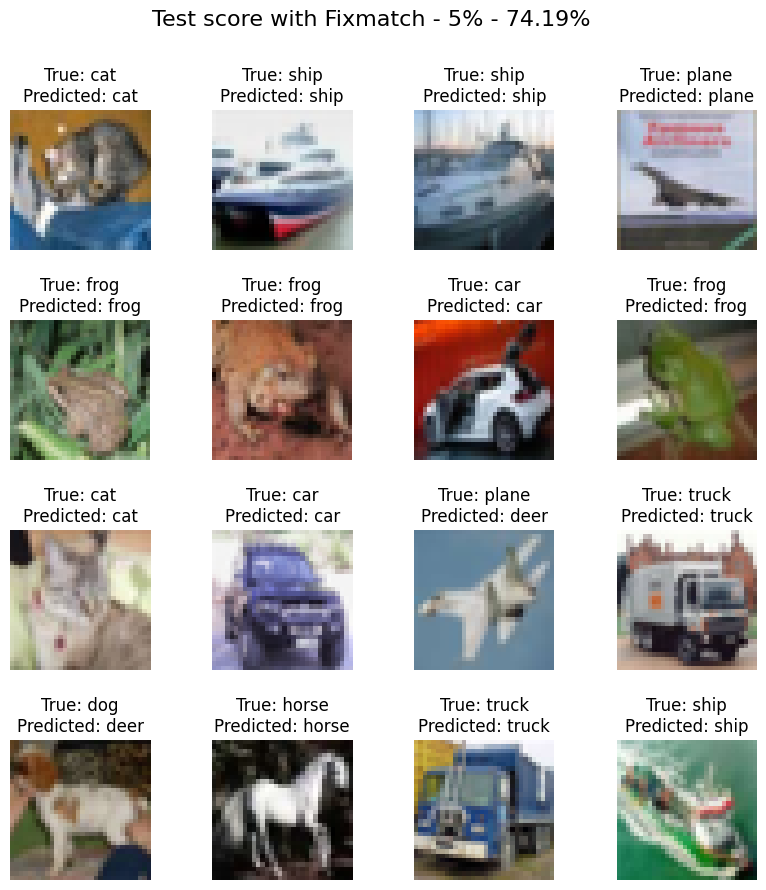

In [22]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_05(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_DA_05_CORESET.png")

### III.3 Fixmatch on 1% train data

In [23]:
# fix the seed
seedEverything()

SUBSET_PROP = 0.01

# load indices
# indices_01 = torch.load('../SPLITS/SPLIT_01_MAX.pt')
indices_01 = torch.load('../SPLITS/SPLIT_01_MAX.pt')

trainset_sup = torch.utils.data.Subset(trainset, indices_01)

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [24]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(labeled_dataloader) * EPOCHS, eta_min=1e-4)

In [25]:
fixmatch_DA_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='01_CORESET'
)

Start training


Epoch     0:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.04%


Epoch     1:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 12.02%


Epoch     2:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 12.65%


Epoch     3:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 18.63%


Epoch     4:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 9.7%


Epoch     5:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 9.99%


Epoch     6:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.03%


Epoch     7:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.28%


Epoch     8:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 13.66%


Epoch     9:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 16.34%


Epoch    10:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 14.82%


Epoch    11:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 16.15%


Epoch    12:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 17.5%


Epoch    13:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 24.68%


Epoch    14:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 25.83%


Epoch    15:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 22.94%


Epoch    16:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 26.6%


Epoch    17:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 25.51%


Epoch    18:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 26.55%


Epoch    19:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.87%


Epoch    20:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.0%


Epoch    21:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.39%


Epoch    22:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.17%


Epoch    23:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 31.96%


Epoch    24:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.26%


Epoch    25:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.26%


Epoch    26:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.34%


Epoch    27:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.79%


Epoch    28:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.59%


Epoch    29:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.92%


Epoch    30:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.47%


Epoch    31:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.42%


Epoch    32:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.89%


Epoch    33:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.58%


Epoch    34:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.88%


Epoch    35:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.46%


Epoch    36:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.5%


Epoch    37:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.33%


Epoch    38:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.48%


Epoch    39:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.97%


Epoch    40:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.53%


Epoch    41:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.54%


Epoch    42:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.4%


Epoch    43:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.19%


Epoch    44:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.08%


Epoch    45:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.8%


Epoch    46:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.31%


Epoch    47:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.9%


Epoch    48:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.11%


Epoch    49:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.07%


Epoch    50:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.66%


Epoch    51:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.5%


Epoch    52:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.86%


Epoch    53:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.81%


Epoch    54:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.27%


Epoch    55:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.81%


Epoch    56:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.97%


Epoch    57:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.81%


Epoch    58:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.55%


Epoch    59:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.65%


Epoch    60:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.25%


Epoch    61:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.6%


Epoch    62:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.51%


Epoch    63:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.97%


Epoch    64:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.93%


Epoch    65:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.81%


Epoch    66:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.91%


Epoch    67:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.11%


Epoch    68:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.92%


Epoch    69:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.2%


Epoch    70:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.09%


Epoch    71:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.71%


Epoch    72:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.13%


Epoch    73:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.97%


Epoch    74:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.68%


Epoch    75:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.62%


Epoch    76:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.04%


Epoch    77:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.05%


Epoch    78:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.56%


Epoch    79:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.01%


Epoch    80:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.25%


Epoch    81:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.14%


Epoch    82:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.23%


Epoch    83:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.59%


Epoch    84:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.16%


Epoch    85:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.59%


Epoch    86:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.95%


Epoch    87:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.31%


Epoch    88:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.2%


Epoch    89:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.81%


Epoch    90:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.74%


Epoch    91:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.39%


Epoch    92:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.87%


Epoch    93:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.99%


Epoch    94:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.31%


Epoch    95:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.51%


Epoch    96:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.69%


Epoch    97:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.84%


Epoch    98:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.39%


Epoch    99:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.72%


Epoch   100:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.36%


Epoch   101:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.0%


Epoch   102:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.07%


Epoch   103:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.66%


Epoch   104:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.82%


Epoch   105:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.91%


Epoch   106:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.88%


Epoch   107:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.07%


Epoch   108:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.7%


Epoch   109:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.25%


Epoch   110:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.2%


Epoch   111:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.26%


Epoch   112:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.48%


Epoch   113:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.33%


Epoch   114:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.43%


Epoch   115:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.89%


Epoch   116:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.55%


Epoch   117:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.07%


Epoch   118:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.79%


Epoch   119:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.59%


Epoch   120:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.31%


Epoch   121:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.14%


Epoch   122:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.77%


Epoch   123:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.2%


Epoch   124:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.77%


Epoch   125:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.7%


Epoch   126:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.84%


Epoch   127:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.5%


Epoch   128:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.15%


Epoch   129:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.31%


Epoch   130:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.89%


Epoch   131:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.88%


Epoch   132:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.49%


Epoch   133:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.43%


Epoch   134:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.03%


Epoch   135:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.84%


Epoch   136:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.32%


Epoch   137:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.82%


Epoch   138:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.13%


Epoch   139:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.06%


Epoch   140:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.12%


Epoch   141:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.56%


Epoch   142:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.62%


Epoch   143:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.21%


Epoch   144:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.77%


Epoch   145:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.95%


Epoch   146:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.16%


Epoch   147:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.95%


Epoch   148:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.35%


Epoch   149:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.42%


Epoch   150:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.51%


Epoch   151:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.33%


Epoch   152:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.52%


Epoch   153:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.57%


Epoch   154:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.09%


Epoch   155:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.44%


Epoch   156:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.74%


Epoch   157:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.12%


Epoch   158:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.68%


Epoch   159:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.62%


Epoch   160:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.45%


Epoch   161:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.9%


Epoch   162:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.93%


Epoch   163:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.46%


Epoch   164:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.15%


Epoch   165:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.5%


Epoch   166:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.04%


Epoch   167:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.66%


Epoch   168:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.27%


Epoch   169:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.85%


Epoch   170:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.48%


Epoch   171:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.31%


Epoch   172:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.39%


Epoch   173:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.0%


Epoch   174:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.92%


Epoch   175:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.23%


Epoch   176:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.36%


Epoch   177:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.48%


Epoch   178:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.69%


Epoch   179:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.46%


Epoch   180:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.24%


Epoch   181:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.52%


Epoch   182:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.96%


Epoch   183:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.32%


Epoch   184:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.88%


Epoch   185:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.45%


Epoch   186:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.61%


Epoch   187:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.71%


Epoch   188:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.86%


Epoch   189:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.32%


Epoch   190:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.35%


Epoch   191:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.2%


Epoch   192:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.81%


Epoch   193:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.26%


Epoch   194:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.03%


Epoch   195:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.08%


Epoch   196:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.38%


Epoch   197:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.21%


Epoch   198:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.94%


Epoch   199:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.14%


Epoch   200:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.28%


Epoch   201:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.31%


Epoch   202:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.71%


Epoch   203:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.13%


Epoch   204:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.98%


Epoch   205:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.06%


Epoch   206:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.63%


Epoch   207:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.26%


Epoch   208:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.74%


Epoch   209:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.84%


Epoch   210:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.89%


Epoch   211:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.36%


Epoch   212:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.19%


Epoch   213:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.83%


Epoch   214:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.6%


Epoch   215:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.71%


Epoch   216:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.68%


Epoch   217:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.7%


Epoch   218:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.42%


Epoch   219:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.01%


Epoch   220:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.82%


Epoch   221:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.6%


Epoch   222:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.76%


Epoch   223:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.39%


Epoch   224:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.5%


Epoch   225:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.66%


Epoch   226:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.47%


Epoch   227:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.88%


Epoch   228:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.3%


Epoch   229:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.81%


Epoch   230:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.27%


Epoch   231:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.24%


Epoch   232:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.9%


Epoch   233:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.56%


Epoch   234:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.55%


Epoch   235:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.07%


Epoch   236:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.75%


Epoch   237:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.89%


Epoch   238:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.94%


Epoch   239:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.28%


Epoch   240:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.09%


Epoch   241:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.17%


Epoch   242:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.14%


Epoch   243:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.15%


Epoch   244:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.26%


Epoch   245:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.55%


Epoch   246:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.42%


Epoch   247:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.05%


Epoch   248:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.84%


Epoch   249:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.2%


Epoch   250:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.6%


Epoch   251:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.4%


Epoch   252:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.19%


Epoch   253:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.37%


Epoch   254:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.21%


Epoch   255:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.91%


Epoch   256:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.13%


Epoch   257:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.12%


Epoch   258:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.94%


Epoch   259:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.03%


Epoch   260:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.78%


Epoch   261:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.23%


Epoch   262:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.18%


Epoch   263:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.9%


Epoch   264:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.01%


Epoch   265:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.9%


Epoch   266:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.89%


Epoch   267:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.14%


Epoch   268:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.21%


Epoch   269:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.11%


Epoch   270:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.0%


Epoch   271:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.27%


Epoch   272:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.2%


Epoch   273:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.2%


Epoch   274:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.29%


Epoch   275:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.16%


Epoch   276:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.39%


Epoch   277:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.48%


Epoch   278:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.51%


Epoch   279:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.5%


Epoch   280:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.5%


Epoch   281:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.57%


Epoch   282:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.52%


Epoch   283:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.43%


Epoch   284:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.29%


Epoch   285:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.3%


Epoch   286:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.26%


Epoch   287:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.3%


Epoch   288:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.26%


Epoch   289:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.3%


Epoch   290:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.17%


Epoch   291:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.16%


Epoch   292:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.23%


Epoch   293:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.26%


Epoch   294:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.26%


Epoch   295:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.21%


Epoch   296:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.19%


Epoch   297:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.26%


Epoch   298:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.26%


Epoch   299:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 52.28%
Finished Training


In [26]:
# open results
model_01 = ConvNN().to(device)
model_01.load_state_dict(torch.load('./results/models/model_DA_01_CORESET.pth'))
train_losses_01 = torch.load('./results/metrics/train_losses_DA_01_CORESET.pth')
train_accuracies_01 = torch.load('./results/metrics/train_accuracies_DA_01_CORESET.pth')
test_losses_01 = torch.load('./results/metrics/test_losses_DA_01_CORESET.pth')
test_accuracies_01 = torch.load('./results/metrics/test_accuracies_DA_01_CORESET.pth')

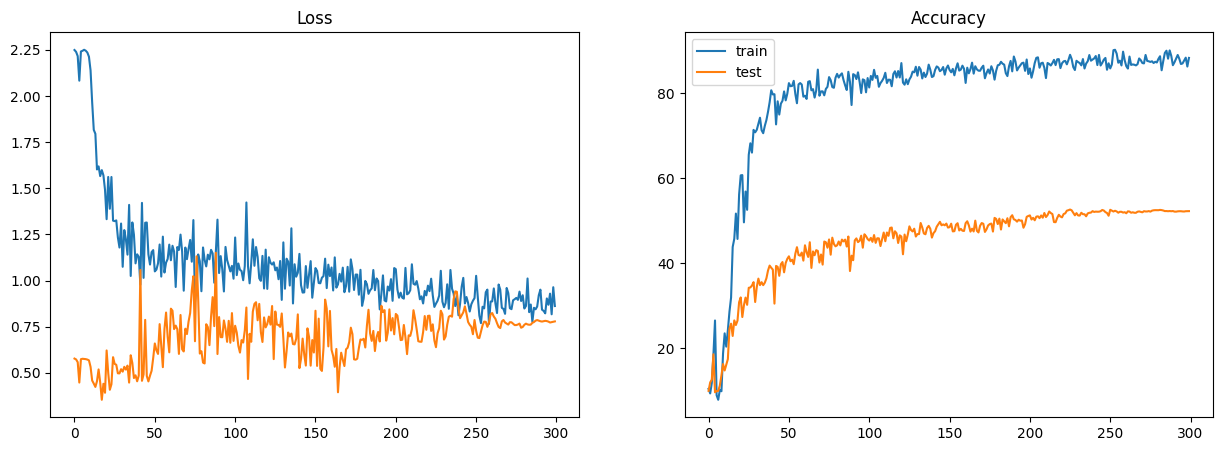

In [27]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_01, label="train")
ax1.plot(test_losses_01, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_01, label="train")
ax2.plot(test_accuracies_01, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_DA_01_CORESET.png")

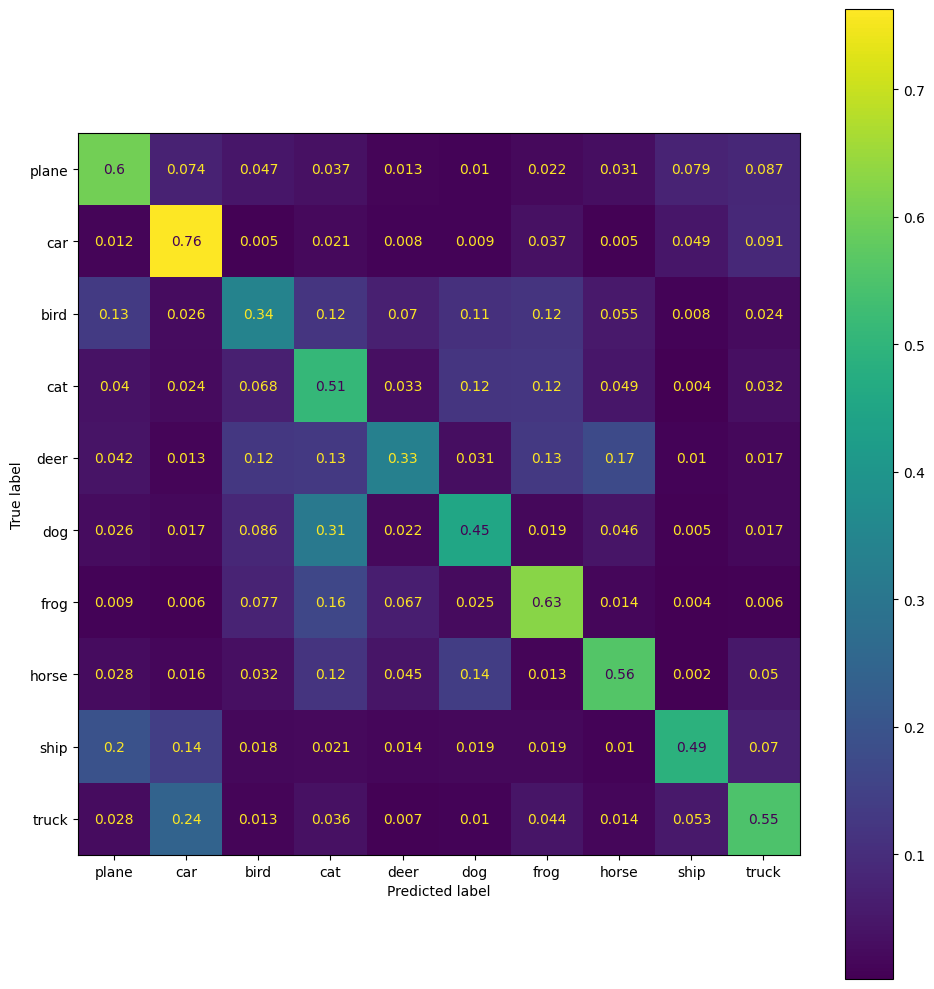

In [28]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_01(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_DA_01_CORESET.png")

Test Accuracy: 52.28%


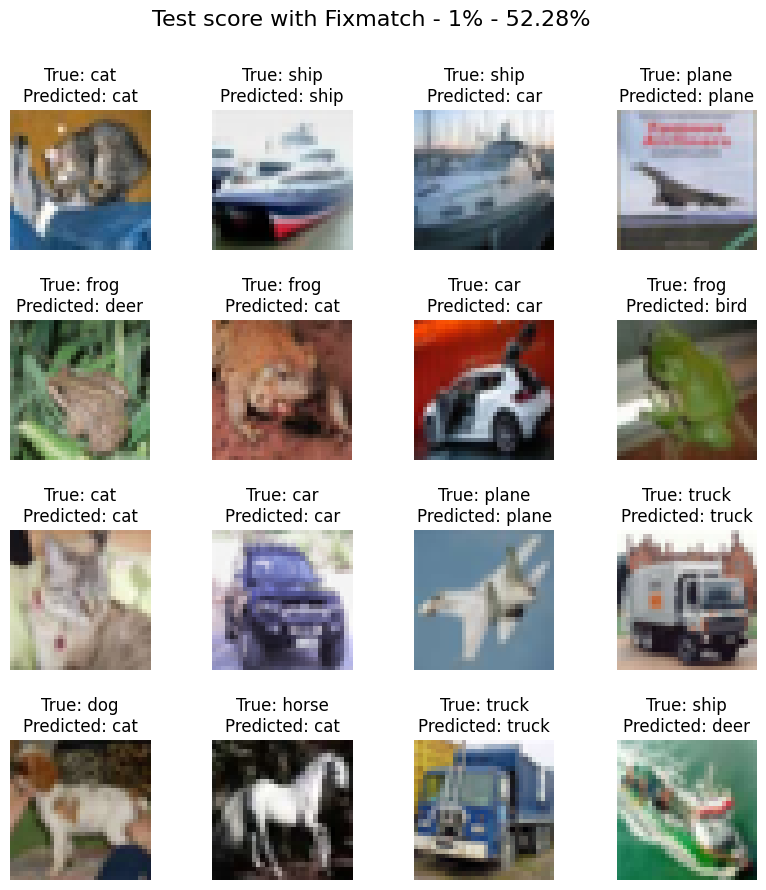

In [29]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_01(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_DA_01_CORESET.png")